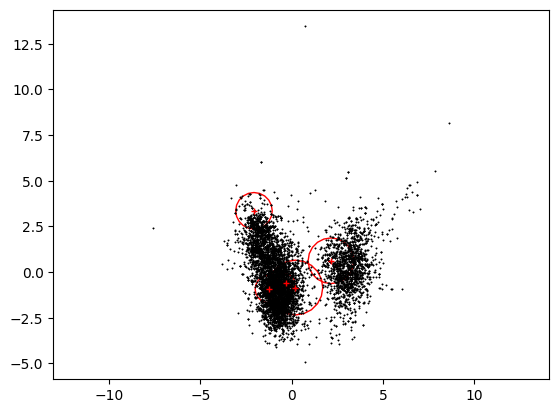

In [9]:
import os
os.chdir( "/home/lucasfuzato/CODING/WINE" )

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import numpy as np
# np.random.seed( 100 )

from sklearn.cluster import DBSCAN
from src.aux_fun import *
from itertools import product

X , norm_X , X_2d , attr = cluster_get_data()

#--------------------------------------------
# plotting the dataset
fig , ax = plt.subplots()
xs = X_2d[ 0 ]
ys = X_2d[ 1 ]
ax.plot( xs , ys , "*k" , markersize = .8 )
ax.axis('equal')

# -------------------------------------
# getting reasonable distances 
dists = np.arange( .5 , 1.6 , .25 )
for dist in dists:

    idx = np.random.randint( len( X ) )
    point = ( xs[ idx ] , ys[ idx ])
    circ = ptc.CirclePolygon( point , dist , fill = False , color = "red" )

    ax.add_patch( circ )
    ax.plot( xs[ idx ] , ys[ idx ] , "+r" , markersize = 5 )

plt.show()



In [15]:
dists = np.arange( 1.5 , 4.6 , .5 )
densities = np.array( [ 10 , 25 , 50 , 100 ] )
# densities *= 2

clist = []
for radius , density in product( dists , densities ):

    d = { "radius" : radius , "density" : density }
    
    DS = DBSCAN( eps = radius , min_samples = density )
    # DS.fit( X_2d.T )
    DS.fit( norm_X )
    labels = DS.labels_

    d[ "num_clusters" ] = len( set( labels ) - { -1 } )
    # print( d )
    
    where_out = ( labels == -1 )
    d[ "num_outliers" ] = sum( map( int , where_out ) )

    cls = d[ "num_clusters" ]
    if not cls:
        # clist.append( d )
        continue 

    soma , total = 0 , 0
    for i in range( cls ):

        where_cls = ( labels == i )
        cls_total = sum( map( int , where_out ) )
        total += cls_total

        cls_score = cluster_score( norm_X[ where_cls ] )
        soma += cls_score*cls_total
    d[ "mean_score" ] = soma/total

    clist.append( d )
df = pd.DataFrame( clist )

print( df )
print( df.loc[ df[ "num_outliers"] < 100 ] )   

    radius  density  num_clusters  num_outliers  mean_score
0      1.5       10             5           808   -1.613792
1      1.5       25             2          1231   -2.390419
2      1.5       50             3          1823   -1.799807
3      1.5      100             2          2856   -1.925690
4      2.0       10             2           226   -2.654336
5      2.0       25             2           334   -2.615768
6      2.0       50             2           412   -2.587734
7      2.0      100             2           551   -2.513573
8      2.5       10             3            85   -2.351106
9      2.5       25             2           127   -2.692323
10     2.5       50             2           167   -2.673374
11     2.5      100             2           194   -2.661560
12     3.0       10             2            38   -2.594159
13     3.0       25             1            64   -3.186714
14     3.0       50             1            70   -3.183765
15     3.0      100             1       

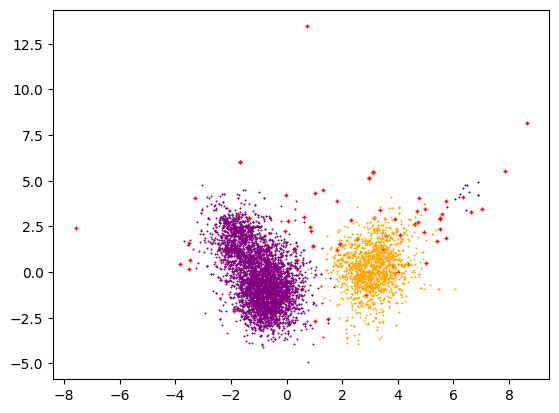

In [17]:
# only those with less than 100 outliers
acceptable = df.loc[ df[ "num_outliers"] < 100 ]

# finding the very best
acceptable.sort_values( "avg_dist" , ascending = False )
best = acceptable.iloc[ -1 ]
# best = acceptable.iloc[ 1 ]

# cluster criteria
radius = best[ "radius" ]
density = int( best[ "density" ] )

# Clustering again
DS = DBSCAN( eps = radius , min_samples = density )
DS.fit( norm_X )
labels = DS.labels_

# plotting the damn cluster
colors = [ "purple" , "orange" , "blue" , "pink" , "grey" ]
fig , ax = plt.subplots()
for i in range( -1 , int( best[ "num_clusters"] ) ):
    
    where = ( labels == i )
    x_where = xs[ where ]
    y_where = ys[ where ]

    # plotting outliers
    if i == -1:
        ax.plot( x_where , y_where , "+r" , markersize = 3 )

    # plotting clusters
    else:
        ax.plot( x_where , y_where , color = colors[ i ] ,  markersize = .8 , ls = "", marker = "*" )

plt.show()

        

In [13]:
# stats for every cluster

df_lst = []
prob_lst = []
for i in range( int( best[ "num_clusters"] ) ):
    where = ( labels == i )
    df , probs = cluster_stats( X[ where ] , attr )
    df_lst.append( df )
    prob_lst.append( probs )

big_df = pd.concat(
    { f"cluster_{i+1}" : df for i , df in enumerate( df_lst ) },
    axis = 1
)

print( big_df )

                     cluster_1         cluster_2         cluster_3        
                          mean     std      mean     std      mean     std
fixed acidity           6.8472   0.828    8.3175   1.731    8.3833   0.402
volatile acidity       0.27682   0.097   0.52913   0.178   0.54958   0.145
citric acid            0.33284   0.117   0.26381   0.191   0.57083   0.118
residual sugar          6.3471   4.946    2.4824   1.175      1.75   0.144
chlorides             0.045394   0.020  0.081746   0.022   0.41492   0.028
free sulfur dioxide     35.168  16.329     15.49   9.864    15.583   3.378
total sulfur dioxide    137.91  41.835    44.982  30.844    53.917  14.315
density                  0.994   0.003   0.99675   0.002   0.99688   0.001
pH                      3.1884   0.151    3.3184   0.149    3.0383   0.059
sulphates              0.48957   0.114   0.64475   0.135    1.2017   0.098
alcohol                 10.514   1.230     10.43   1.050    9.2167   0.121


In [18]:
# meta information of the clusters
meta_df = pd.DataFrame( index = [ "red_prob" , "num_entries" , "avg_dist" ]  )
for i in range( int( best[ "num_clusters"] ) ):

    red_prob = prob_lst[ i ]

    where = ( labels == i )
    num_entries = int( sum( map( int , where ) ) )

    X_where = norm_X[ where ]
    score = cluster_score( X_where )

    cls_name = f"cluster_{ i + 1 }"
    meta_df[ cls_name ] = pd.Series(
        [ red_prob , num_entries , score ],  
        index = [ "red_prob" , "num_entries" , "avg_dist" ] 
    )

print( meta_df )

               cluster_1    cluster_2  cluster_3
red_prob        0.000617     1.000000   1.000000
num_entries  4863.000000  1537.000000  12.000000
score          -2.653191    -2.762869  -1.637257
